# Transformer for forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

In [2]:
def random_seed_set(seed):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## load data

In [3]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## normalization

In [4]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [5]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len, dim_1))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, :]
    print("supervised data: shape of x: {}, shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [6]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## Transform model

### PositionalEncoding

In [7]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的 `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

### DotProduct Attention

In [8]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行 softmax 操作"""
    # `X`: 3D张量，`valid_lens`: 1D或2D 张量
    # valid_lens 为 None 正常softmax
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `queries` 的形状：(`batch_size`，查询的个数，`d`)
    # `keys` 的形状：(`batch_size`，“键－值”对的个数，`d`)
    # `values` 的形状：(`batch_size`，“键－值”对的个数，值的维度)
    # `valid_lens` 的形状: (`batch_size`，) 或者 (`batch_size`，查询的个数)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置 `transpose_b=True` 为了交换 `keys` 的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

### MultiHead Attention

In [9]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self,
                 key_size,
                 query_size,
                 value_size,
                 num_hiddens,
                 num_heads,
                 dropout,
                 bias=False,
                 **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens=None):
        # `queries`，`keys`，`values` 的形状:
        # (`batch_size`，查询或者“键－值”对的个数，`num_hiddens`)
        # `valid_lens`　的形状:
        # (`batch_size`，) 或 (`batch_size`，查询的个数)
        # 经过变换后，输出的 `queries`，`keys`，`values`　的形状:
        # (`batch_size` * `num_heads`，查询或者“键－值”对的个数，
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴 0，将第一项（标量或者矢量）复制 `num_heads` 次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)

        # `output` 的形状: (`batch_size` * `num_heads`，查询的个数，
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # `output_concat` 的形状: (`batch_size`，查询的个数，`num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状。"""
    # 输入 `X` 的形状: (`batch_size`，查询或者“键－值”对的个数，`num_hiddens`)
    # 输出 `X` 的形状: (`batch_size`，查询或者“键－值”对的个数，`num_heads`，
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出 `X` 的形状: (`batch_size`，`num_heads`，查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状: (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转 `transpose_qkv` 函数的操作。"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

### PositionWiseFFN

In [10]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

### Add&Norm

In [11]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

### Encoder

In [12]:
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self,
                 key_size,
                 query_size,
                 value_size,
                 num_hiddens,
                 norm_shape,
                 ffn_num_input,
                 ffn_num_hiddens,
                 num_heads,
                 dropout,
                 use_bias=False,
                 **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
    
    
class TransformerEncoder(nn.Module):
    """transformer编码器"""
    def __init__(self, input_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Linear(input_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens=None, *args):
        # 因为位置编码值在 -1 和 1 之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        # pdb.set_trace()
        # X shape (batch_size, num_steps, input_size)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
        return X

### Decoder

In [13]:
class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此 `state[2][self.i]` 初始化为 `None`。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此 `state[2][self.i]` 包含着直到当前时间步第 `i` 个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # `dec_valid_lens` 的开头: (`batch_size`, `num_steps`),
            # 其中每一行是 [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # `enc_outputs` 的开头: (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

    
class TransformerDecoder(nn.Module):
    """transformer解码器"""
    def __init__(self, input_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Linear(input_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, 1)


    def forward(self, X, state):
        # X shape (batch_size, num_steps, input_size)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

### Transformer

In [47]:
class Transformer(nn.Module):
    """完整transformer模型"""
    def __init__(self, input_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.encoder = TransformerEncoder(input_size, key_size, query_size,
                                          value_size, num_hiddens,
                                          norm_shape[0], ffn_num_input,
                                          ffn_num_hiddens, num_heads,
                                          num_layers, dropout)
        self.decoder = TransformerDecoder(input_size, key_size, query_size,
                                          value_size, num_hiddens,
                                          norm_shape[1], ffn_num_input,
                                          ffn_num_hiddens, num_heads,
                                          num_layers, dropout)

    def forward(self, enc_inputs, dec_inputs):
        enc_outputs = self.encoder(enc_inputs)
        state = [enc_outputs, None, [None] * self.num_layers]

        outputs = []
        # without teacher forcing
        # if self.training:
        #    outputs, state = self.decoder(dec_inputs, state)
        # else:
        for i in range(dec_inputs.shape[1]):
            if i:
                x = torch.cat((dec_inputs[:, i:i + 1, :-1], out.detach()),
                              dim=-1)
            else:
                x = dec_inputs[:, i:i+1, :]
            out, state = self.decoder(x, state)
            outputs.append(out)
        outputs = torch.cat(outputs, dim=1)
        return outputs.reshape(outputs.shape[0], -1)

### model tets

In [15]:
transformer = Transformer(16, 32, 32, 32, 32, ([32], [32]), 32, 64, 4, 2, 0.1)
# decoder = TransformerDecoder(16, 32, 32, 32, 32, [24, 32], 32, 64, 4, 2, 0.1)
enc_inputs = torch.randn(10, 72, 16)
dec_inputs = torch.randn(10, 24, 16)
# enc_outputs = torch.randn(10, 72, 32)
# state = [enc_outputs, None, [None] * 2]
transformer.eval()
outputs = transformer(enc_inputs, dec_inputs)
outputs.shape

torch.Size([10, 24])

## model training for HPO

In [62]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, seq_len, target_len, mse_thresh, d_model,
                    nhead, n_layers, number_epoch, batch_size, lr, drop_prob):
    """寻找超参数的训练函数，有early stop"""
    valid_steps = 5
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = Transformer(input_size, d_model, d_model, d_model, d_model,
                                ([d_model], [d_model]),
                                d_model, 2 * d_model, nhead, n_layers,
                                drop_prob)
            model = model.to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(),
                                         lr=lr,
                                         betas=(0.9, 0.98),
                                         eps=1e-9)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=1,
                                                        gamma=0.98)
            valid_loss_min = np.Inf
            print('train dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))

            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            train_losses = list()

            num_without_imp = 0

            #train
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True, ncols=100)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    # train                    
                    model.train()
                    enc_inputs = inputs
                    dec_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                    outputs = model(enc_inputs, dec_inputs)
                    loss = criterion(outputs, labels[:, :, -1])
                    train_losses.append(loss.item)
                    loss.backward()
                    optimizer.step()

                    # eval
                    if i % valid_steps == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            enc_inputs = inp
                            dec_inputs = torch.cat((inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                            out = model(enc_inputs, dec_inputs)
                            valid_loss = criterion(out, lab[:, :, -1])
                            valid_losses.append(valid_loss.item())
                        loop.set_description("Epoch: {}/{}...".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp > 50:
                    pass
                    # break
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [91]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [256]
    lrs = [0.01, 0.005, 0.001]
    number_epochs = [40]
    d_models = [32, 64, 96]
    n_layers = [2, 3]
    drop_prob = [0.5]
    nhead = [4, 8]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in d_models:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in nhead:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'd_model': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'nhead': o
                                })
    return configs

## random search for HPO

In [92]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #         with enough data
    train_x_list = train_x_list[-1:]
    train_y_list = train_y_list[-1:]
    valid_x_list = valid_x_list[-1:]
    valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    for i in range(18):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        d_model = config['d_model']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        nhead = config['nhead']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, d_model-{}, n_layers-{},drop_prob-{},nhead-{}"
            .format(batch_size, lr, number_epoch, d_model, n_layers, drop_prob,
                    nhead))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, seq_len,
                                     target_len, mse_thresh, d_model, nhead,
                                     n_layers, number_epoch, batch_size, lr,
                                     drop_prob)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'd_model': d_model,
            'n_layers': n_layers,
            'drop_prob': drop_prob,            
            'nhead': nhead,
            'valid_loss': valid_loss,
        })
    return records

## run random search

In [ ]:
random_seed_set(42)
records = run_model_hpo()

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)
model config: batch_size-256, lr-0.001, number_epoch-40, d_model-32, n_layers-2,drop_prob-0.5,nhead-8
train dataset 0


Epoch: 20/40...:  49%|██▉   | 40/82 [00:12<00:09,  4.44it/s, train_loss=0.00293, valid_loss=0.00607]

## find the best hyper-parameters

In [94]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/transformer_records.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,d_model,n_layers,drop_prob,nhead,valid_loss
6,256,0.001,40,96,3,0.5,8,0.002061
3,256,0.001,40,64,3,0.5,8,0.002103
17,256,0.010,40,32,2,0.5,4,0.002152
12,256,0.001,40,96,2,0.5,8,0.002181
8,256,0.001,40,32,2,0.5,4,0.002566
1,256,0.001,40,64,2,0.5,4,0.002612
0,256,0.001,40,32,2,0.5,8,0.003784
15,256,0.001,40,64,3,0.5,4,0.003925
5,256,0.005,40,64,3,0.5,4,0.004980
9,256,0.005,40,64,2,0.5,8,0.005084


## retrain a model

In [22]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, seq_len,
                target_len, mse_thresh, d_model, nhead, n_layers, number_epoch,
                batch_size, lr, drop_prob):
    while (1):
        model = Transformer(input_size, d_model, d_model, d_model, d_model,
                                ([d_model], [d_model]),
                                d_model, 2 * d_model, nhead, n_layers,
                                drop_prob)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr,
                                     betas=(0.9, 0.98),
                                     eps=1e-9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=1,
                                                    gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        train_loss_list = []
        valid_loss_list = []
        num_without_imp = 0

        #train
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True, ncols=100)
            for i, (inputs, labels) in loop:
                model.train()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # train
                # pdb.set_trace()
                enc_inputs = inputs
                dec_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                outputs = model(enc_inputs, dec_inputs)
                loss = criterion(outputs, labels[:, :, -1])
                loss.backward()
                optimizer.step()

                # eval
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        enc_inputs = inp
                        dec_inputs = torch.cat((inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                        out = model(enc_inputs, dec_inputs)
                        valid_loss = criterion(out, lab[:, :, -1])
                        valid_losses.append(valid_loss.item())
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   "./model/transformer_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [23]:
def test_model(model, test_x, test_y, scaler_y, seq_len, target_len,
               batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=True)
    model.load_state_dict(torch.load('./model/transformer_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        model.eval()
        for inp, lab in test_loader:
            inp = inp.to(device)
            lab = lab.to(device)
            enc_inputs = inp
            dec_inputs = torch.cat((inp[:, -1:, :], lab[:, :-1, :]), dim=1)
            out = model(enc_inputs, dec_inputs)
            y_pred += out.cpu().numpy().flatten().tolist()
            y_true += lab[:, :, -1].cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [102]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]

    #     hyper-parameters define
    batch_size = 256
    lr = 0.001
    number_epoch = 40
    d_model = 64
    n_layers = 2
    drop_prob = 0.5
    nhead = 8
    mse_thresh = 0.1

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, seq_len, target_len,
        mse_thresh, d_model, nhead, n_layers, number_epoch, batch_size, lr,
        drop_prob)
    # plot training process
    plt.plot(train_loss_list[10:], 'm', label='train_loss')
    plt.plot(valid_loss_list[10:], 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    # test
    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, seq_len,
                                                       target_len, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)


Epoch: 40/40...: 100%|██████| 78/78 [00:26<00:00,  2.94it/s, train_loss=0.00107, valid_loss=0.00352]


supervised data: shape of x: (6237, 72, 16), shape of y: (6237, 24, 16)
MAPE:0.05084572387857614, MAE:647.523400409149, RMSE:866.8882102514918


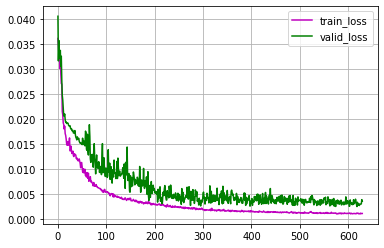

In [103]:
random_seed_set(42)
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

In [104]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.05084572387857614, MAE:647.523400409149, RMSE:866.8882102514918


## figure plot

In [ ]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[:240, 0], 'm')
plt.plot(load_true[:240, 0], 'g')
plt.ylim(ymin=0)

(0.0, 20178.594054892717)